In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zipfile
import random
import os
from torchvision.transforms import InterpolationMode
from torchvision.datasets import ImageFolder
from torchvision import models
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import random_split
from torch.utils.data import Subset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset, DataLoader
from torch.utils.data import Subset, DataLoader, Dataset
from PIL import Image
from tqdm import tqdm


torch.manual_seed(42)

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/My Drive/house_plant_species.zip'

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/house_plant_species')
    file_list = zip_ref.namelist()
    print("Files in ZIP:")
    for file in file_list:
        print(file)

Files in ZIP:
house_plant_species/African Violet (Saintpaulia ionantha)/
house_plant_species/African Violet (Saintpaulia ionantha)/1.jpg
house_plant_species/African Violet (Saintpaulia ionantha)/10.jpg
house_plant_species/African Violet (Saintpaulia ionantha)/100.jpg
house_plant_species/African Violet (Saintpaulia ionantha)/101.jpg
house_plant_species/African Violet (Saintpaulia ionantha)/102.jpg
house_plant_species/African Violet (Saintpaulia ionantha)/103.jpg
house_plant_species/African Violet (Saintpaulia ionantha)/104.jpg
house_plant_species/African Violet (Saintpaulia ionantha)/105.jpg
house_plant_species/African Violet (Saintpaulia ionantha)/106.jpg
house_plant_species/African Violet (Saintpaulia ionantha)/107.jpg
house_plant_species/African Violet (Saintpaulia ionantha)/108.jpg
house_plant_species/African Violet (Saintpaulia ionantha)/109.jpg
house_plant_species/African Violet (Saintpaulia ionantha)/11.jpg
house_plant_species/African Violet (Saintpaulia ionantha)/110.jpg
house_p

In [ ]:
dataset_root = '/content/house_plant_species/house_plant_species'

# Lists to store dimensions
heights = []
widths = []
channels = []

for class_name in os.listdir(dataset_root):
    class_path = os.path.join(dataset_root, class_name)
    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                mode = img.mode

                # Determine number of channels from mode
                if mode == 'RGB':
                    ch = 3
                elif mode == 'RGBA':
                    ch = 4
                elif mode == 'L':
                    ch = 1
                else:
                    # Unknown mode
                    ch = None

                if ch is not None:
                    widths.append(width)
                    heights.append(height)
                    channels.append(ch)
        except Exception as e:
            print(f"Error reading {img_path}: {e}")

# Convert to NumPy arrays for easy stats
widths = np.array(widths)
heights = np.array(heights)
channels = np.array(channels)

print(f"Number of images processed: {len(widths)}")

# Width stats
print(f"Width - Min: {widths.min()}, Max: {widths.max()}, Average: {widths.mean():.2f}")

# Height stats
print(f"Height - Min: {heights.min()}, Max: {heights.max()}, Average: {heights.mean():.2f}")

# Channels stats
print(f"Channels - Unique values: {set(channels)}")

Number of images processed: 14677
Width - Min: 90, Max: 6720, Average: 1309.39
Height - Min: 120, Max: 8021, Average: 1336.51
Channels - Unique values: {np.int64(3), np.int64(4)}


In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
dataset = ImageFolder(root='/content/house_plant_species/house_plant_species',transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

targets = np.array([label for _, label in dataset])

# Perform stratified random split (80% train, 20% test)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(split.split(np.zeros(len(targets)), targets))

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Total training samples: {len(train_dataset)}")
print(f"Total test samples: {len(test_dataset)}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Total number of images: {len(dataset)}")

Training batches: 185
Test batches: 47
Total training samples: 11819
Total test samples: 2955


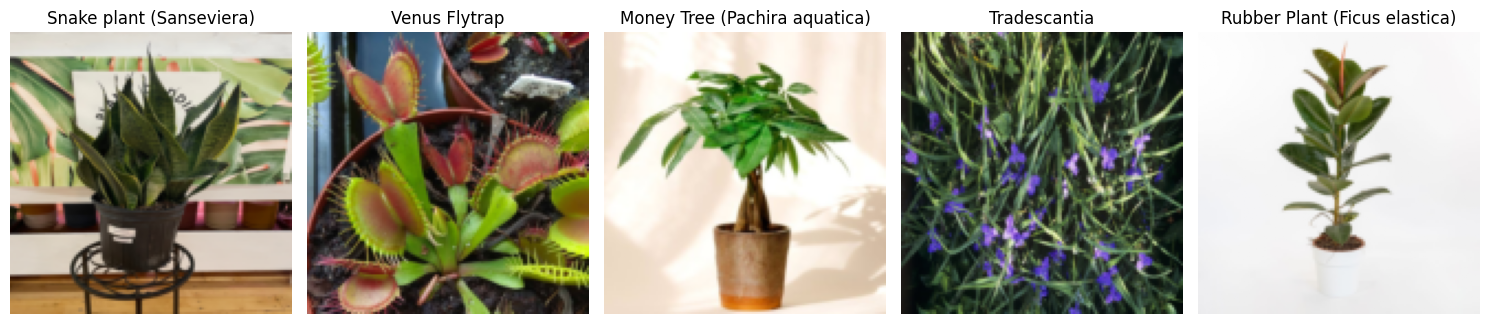

In [ ]:
# Function to denormalize the image
def denormalize(img_tensor):
    img = img_tensor.clone()
    img = img * 0.5 + 0.5  # reverse normalization
    return img

# Get class names
class_names = dataset.classes

# Show some random images from the training dataset
def show_random_images(train_dataset, num_images=5):
    indices = np.random.choice(len(train_dataset), num_images, replace=False)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, idx in enumerate(indices):
        image, label = train_dataset[idx]
        image = denormalize(image)
        image_np = image.permute(1, 2, 0).numpy()  # CxHxW to HxWxC

        axes[i].imshow(image_np)
        axes[i].set_title(class_names[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
show_random_images(train_dataset)

In [ ]:
random_idx = torch.randint(0, len(train_dataset), (1,)).item()

# Get the image tensor and label
image_tensor, label = train_dataset[random_idx]

# Print tensor info
print(f"Class label: {label} ({dataset.classes[label]})")
print(f"Tensor shape: {image_tensor.shape}")
print(f"Tensor values (partial):\n{image_tensor[:, :5, :5]}")  # show top-left 5x5 pixels of all 3 channels


Class label: 16 (Daffodils (Narcissus spp.))
Tensor shape: torch.Size([3, 128, 128])
Tensor values (partial):
tensor([[[-0.8510, -0.8745, -0.8902, -0.8588, -0.8039],
         [-0.8510, -0.8745, -0.8667, -0.8353, -0.7961],
         [-0.8588, -0.8667, -0.8431, -0.8039, -0.7647],
         [-0.8510, -0.8588, -0.8118, -0.7725, -0.7333],
         [-0.8353, -0.8353, -0.7882, -0.7412, -0.6863]],

        [[-0.7647, -0.7647, -0.7490, -0.7176, -0.6627],
         [-0.7333, -0.7490, -0.7333, -0.6941, -0.6314],
         [-0.7098, -0.7255, -0.7020, -0.6549, -0.5843],
         [-0.6863, -0.7098, -0.6706, -0.6078, -0.5373],
         [-0.6706, -0.6784, -0.6314, -0.5451, -0.4902]],

        [[-0.9529, -0.9529, -0.9373, -0.9137, -0.8667],
         [-0.9529, -0.9451, -0.9294, -0.8980, -0.8431],
         [-0.9765, -0.9373, -0.9059, -0.8588, -0.8039],
         [-0.9686, -0.9529, -0.8745, -0.8196, -0.7647],
         [-0.9765, -0.9529, -0.8510, -0.7725, -0.7176]]])


In [ ]:
num_classes = len(dataset.classes)

In [ ]:
def MScnn(num_classes):
    # Feature extraction
    feature_extractor = nn.Sequential(
        nn.Conv2d(3, 6, kernel_size=5),    # Output: (128 - 5 + 1) = 124 → 6x124x124
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                # → 6x62x62
        nn.Conv2d(6, 16, kernel_size=5),   # → (62 - 5 + 1) = 58 → 16x58x58
        nn.ReLU(),
        nn.MaxPool2d(2, 2)                 # → 16x29x29
    )

    # Fully connected classifier
    classifier = nn.Sequential(
        nn.Linear(16 * 29 * 29, 120),      # Flattened features
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, num_classes)         # Output layer
    )

    # Forward pass function
    def forward_function(x):
        x = feature_extractor(x)
        x = torch.flatten(x, 1)  # flatten all except batch
        x = classifier(x)
        return x

    # Build full model
    model = nn.Sequential(feature_extractor, nn.Flatten(), classifier)
    model.forward = forward_function

    return model

In [ ]:
# Get number of classes from ImageFolder
num_classes = len(dataset.classes)

# Initialize model
model = MScnn(num_classes)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, test_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        test_acc = evaluate_model(model, test_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, "
              f"Test Acc: {test_acc:.2f}%")

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Train the model
train_model(model, train_loader, test_loader, num_epochs=10)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Loss: 3.3205, Train Acc: 12.29%, Test Acc: 20.07%


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [2/10], Loss: 2.7619, Train Acc: 24.66%, Test Acc: 26.23%


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [3/10], Loss: 2.3523, Train Acc: 34.03%, Test Acc: 29.54%


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [4/10], Loss: 1.9357, Train Acc: 45.34%, Test Acc: 31.13%


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [5/10], Loss: 1.5318, Train Acc: 55.89%, Test Acc: 30.93%


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [6/10], Loss: 1.1150, Train Acc: 67.15%, Test Acc: 29.48%


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [7/10], Loss: 0.7394, Train Acc: 78.32%, Test Acc: 29.54%


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [8/10], Loss: 0.4189, Train Acc: 87.69%, Test Acc: 28.60%


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [9/10], Loss: 0.2441, Train Acc: 92.76%, Test Acc: 28.70%


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [10/10], Loss: 0.1371, Train Acc: 96.15%, Test Acc: 27.72%


In [ ]:
def evaluate_and_analyze(model, test_loader, class_names):
    model.eval()
    correct = 0
    total = 0
    wrong_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store wrong predictions
            for i in range(inputs.size(0)):
                if predicted[i] != labels[i]:
                    wrong_preds.append((inputs[i].cpu(), predicted[i].cpu().item(), labels[i].cpu().item()))

    acc = 100 * correct / total
    error_rate = 100 - acc

    print(f"\nTest Accuracy: {acc:.2f}%")
    print(f"Correct Predictions: {correct}")
    print(f"Incorrect Predictions: {total - correct}")
    print(f"Error Rate: {error_rate:.2f}%")

    # Show up to 12 wrong predictions
    num_show = min(12, len(wrong_preds))
    if num_show > 0:
        print(f"\nShowing {num_show} misclassified images:")
        fig, axes = plt.subplots(3, 4, figsize=(15, 10))
        for i, (img_tensor, pred, actual) in enumerate(wrong_preds[:num_show]):
            img = img_tensor.permute(1, 2, 0)  # C x H x W -> H x W x C
            img = img * 0.5 + 0.5  # Unnormalize from [-1,1] to [0,1]

            ax = axes[i // 4, i % 4]
            ax.imshow(img.numpy())
            ax.set_title(f"Pred: {class_names[pred]}\nActual: {class_names[actual]}")
            ax.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print("No misclassified images found.")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Test Accuracy: 27.72%
Correct Predictions: 819
Incorrect Predictions: 2136
Error Rate: 72.28%

Showing 12 misclassified images:


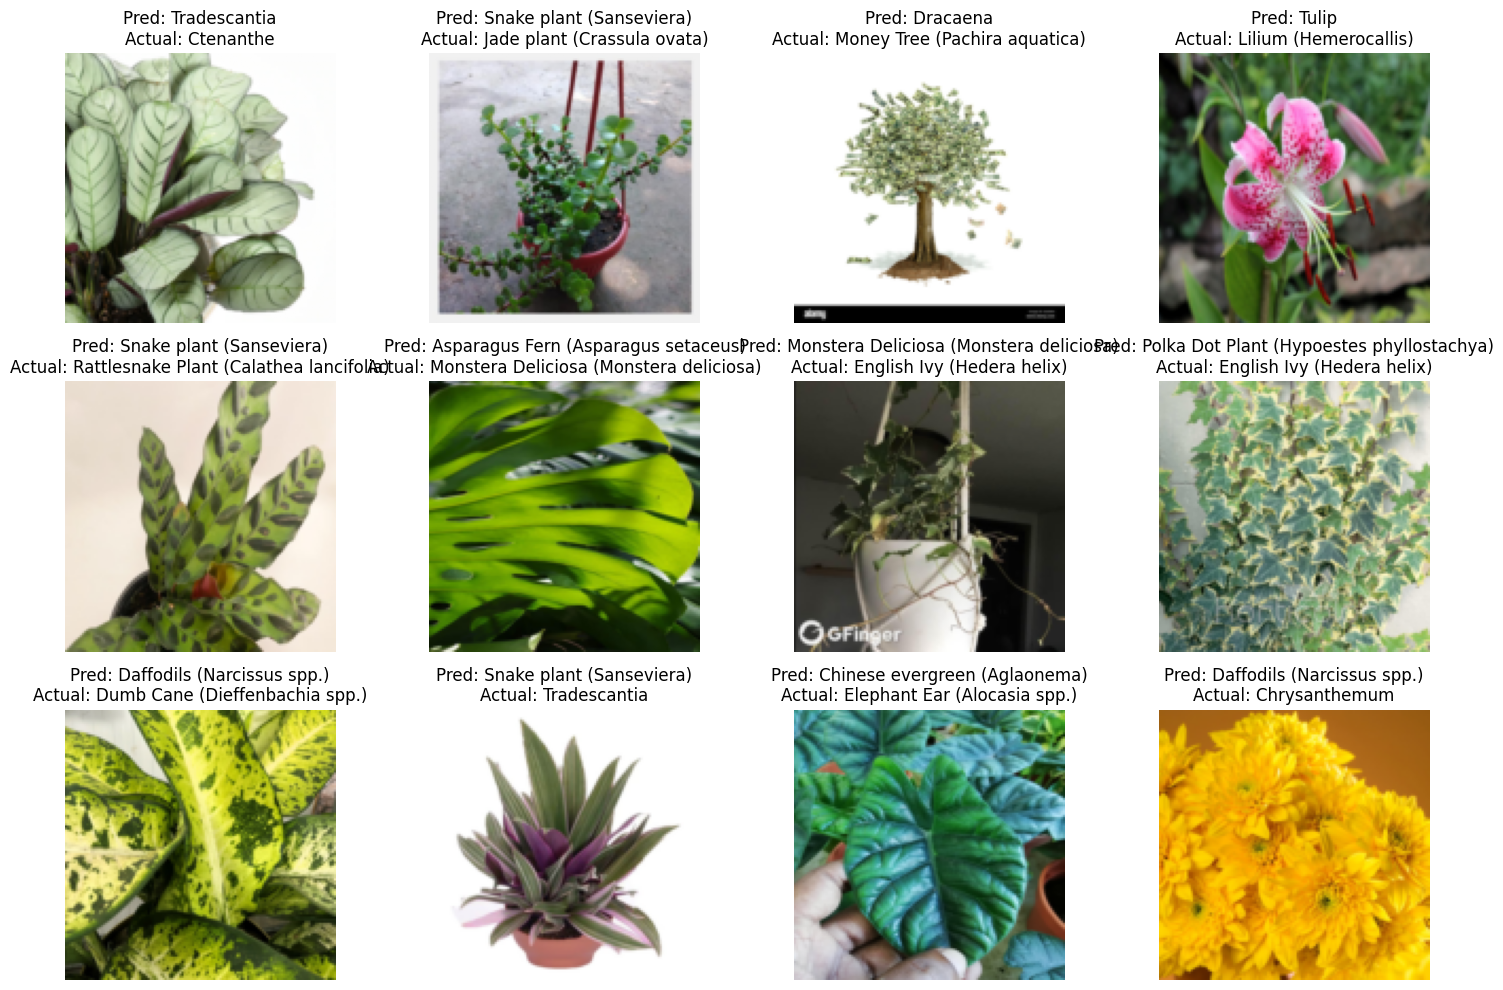

In [ ]:
class_names = dataset.classes  # or: train_loader.dataset.dataset.classes
evaluate_and_analyze(model, test_loader, class_names)


In [ ]:
def convert_palette_images_to_rgb(root_dir, save_new=False):
    """
    Convert all 'P' mode images (with or without transparency) in the dataset to 'RGB'.

    Args:
        root_dir (str): Root path of your ImageFolder dataset.
        save_new (bool): If True, saves a new copy with '_rgb' appended; otherwise overwrites.
    """
    converted_count = 0
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.webp')):    # '.jpg', '.jpeg', '.png', '.bmp', '.gif','.webp'
                continue

            file_path = os.path.join(dirpath, filename)
            try:
                with Image.open(file_path) as img:
                    if img.mode == 'P':
                        rgb_img = img.convert('RGB')
                        if save_new:
                            name, ext = os.path.splitext(filename)
                            new_path = os.path.join(dirpath, f"{name}_rgb{ext}")
                            rgb_img.save(new_path)
                        else:
                            rgb_img.save(file_path)
                        converted_count += 1
            except Exception as e:
                print(f"Failed to process {file_path}: {e}")

    print(f"\n✅ Finished. Converted {converted_count} 'P' mode images to RGB.")


In [ ]:
convert_palette_images_to_rgb('/content/house_plant_species/house_plant_species', save_new=False)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



✅ Finished. Converted 112 'P' mode images to RGB.


In [ ]:
def delete_corrupted_images(root_dir):
    from PIL import Image
    import os

    deleted = 0
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.webp')):
                continue

            file_path = os.path.join(dirpath, filename)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Just checks file integrity, doesn't load all pixels
            except Exception as e:
                print(f"Deleting corrupted file: {file_path} ({e})")
                os.remove(file_path)
                deleted += 1

    print(f"\n✅ Deleted {deleted} corrupted/unreadable images.")

In [ ]:
delete_corrupted_images('/content/house_plant_species/house_plant_species')


✅ Deleted 0 corrupted/unreadable images.


In [ ]:
# Risize data first
transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])

# Load the dataset without normalization
dataset = ImageFolder(root='/content/house_plant_species/house_plant_species', transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)


In [ ]:
# Compute mean and std
mean = 0.
std = 0.
n_samples = 0

for images, _ in tqdm(loader):
    batch_samples = images.size(0)  # batch size (the last batch can be smaller)
    images = images.view(batch_samples, images.size(1), -1)  # (B, C, H*W)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    n_samples += batch_samples

mean /= n_samples
std /= n_samples

print(f"Computed mean: {mean}")
print(f"Computed std: {std}")

100%|██████████| 231/231 [09:37<00:00,  2.50s/it]

Computed mean: tensor([0.5463, 0.5445, 0.4464])
Computed std: tensor([0.2399, 0.2205, 0.2453])


In [ ]:
dataset = ImageFolder(root='/content/house_plant_species/house_plant_species')
labels = [label for _, label in dataset]

train_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=InterpolationMode.BILINEAR),
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), shear=15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.9, contrast=0.9),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
val_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Create an initial train/test split (e.g., 80% train+val, 20% test)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(split.split(np.zeros(len(labels)), labels))

train_val_subset = Subset(dataset, train_val_idx)
test_subset = Subset(dataset, test_idx)

# Wrapper to apply transforms to subsets [transformwrapper]
class TW(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.subset[index]
        return self.transform(image), label

    def __len__(self):
        return len(self.subset)

# Apply kfold cross-validation
labels_train_val = [labels[i] for i in train_val_idx]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels_train_val)), labels_train_val)):
    print(f"\n=== Fold {fold+1} ===")

    train_subset = Subset(train_val_subset, train_idx)
    val_subset = Subset(train_val_subset, val_idx)

    train_data = TW(train_subset, train_transform)
    val_data = TW(val_subset, val_transform)

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2)

    test_data = TW(test_subset, test_transform)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)


=== Fold 1 ===

=== Fold 2 ===

=== Fold 3 ===

=== Fold 4 ===

=== Fold 5 ===


In [ ]:
# Custom weight initialization function
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

# Updated CNN model
class ThirdMScnn(nn.Module):
    def __init__(self, num_classes):
        super(ThirdMScnn, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),      # → 6x124x124
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                  # → 6x62x62
            nn.Dropout(0.25),

            nn.Conv2d(6, 16, kernel_size=3),     # → 16x60x60
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                  # → 16x30x30
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 30 * 30, 120),
            nn.ReLU(),

            nn.Linear(120, 84),
            nn.ReLU(),

            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)  # Flatten all but batch
        x = self.classifier(x)
        return x

In [ ]:
# Number of classes from ImageFolder
num_classes = len(dataset.classes)

# Initializing model
model = ThirdMScnn(num_classes)
model.apply(init_weights)

ThirdMScnn(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=14400, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=47, bias=True)
  )
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_model(model, train_loader, val_loader, test_loader, num_epochs=20, lr=0.001, weight_decay=1e-4):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    batch_losses = []
    epoch_train_acc = []
    epoch_val_acc = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())  # Save batch loss

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        epoch_train_acc.append(train_acc)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss_total = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss_total += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        val_loss_avg = val_loss_total / len(val_loader)
        epoch_val_acc.append(val_acc)

        scheduler.step(val_loss_avg)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # Final Test Accuracy
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    print(f"\nFinal Test Accuracy: {test_accuracy:.2f}%")
# Plot Loss Curve
    plt.figure(figsize=(10, 4))
    plt.plot(batch_losses)
    plt.title("Training Loss per Batch")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

 # Plot Accuracy Curve
    plt.figure(figsize=(10, 4))
    plt.plot(epoch_train_acc, label="Train Accuracy")
    plt.plot(epoch_val_acc, label="Val Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)
    plt.show()
    return model, batch_losses, epoch_train_acc, epoch_val_acc

Epoch [1/20], Loss: 3.7200, Train Acc: 3.81%, Val Acc: 6.56%
Epoch [2/20], Loss: 3.4464, Train Acc: 6.82%, Val Acc: 8.51%
Epoch [3/20], Loss: 3.4120, Train Acc: 8.54%, Val Acc: 9.44%
Epoch [4/20], Loss: 3.1666, Train Acc: 9.25%, Val Acc: 12.06%
Epoch [5/20], Loss: 3.1588, Train Acc: 9.62%, Val Acc: 11.30%
Epoch [6/20], Loss: 3.0785, Train Acc: 10.69%, Val Acc: 12.23%
Epoch [7/20], Loss: 3.1652, Train Acc: 11.03%, Val Acc: 12.95%
Epoch [8/20], Loss: 3.1107, Train Acc: 11.55%, Val Acc: 12.40%
Epoch [9/20], Loss: 3.1090, Train Acc: 11.34%, Val Acc: 13.12%
Epoch [10/20], Loss: 3.0969, Train Acc: 12.01%, Val Acc: 13.80%
Epoch [11/20], Loss: 3.1413, Train Acc: 12.14%, Val Acc: 13.63%
Epoch [12/20], Loss: 3.0732, Train Acc: 12.34%, Val Acc: 13.08%
Epoch [13/20], Loss: 3.0774, Train Acc: 12.77%, Val Acc: 13.08%
Epoch [14/20], Loss: 3.0425, Train Acc: 12.56%, Val Acc: 14.35%
Epoch [15/20], Loss: 2.9898, Train Acc: 13.00%, Val Acc: 14.09%
Epoch [16/20], Loss: 3.0288, Train Acc: 12.73%, Val Acc: 

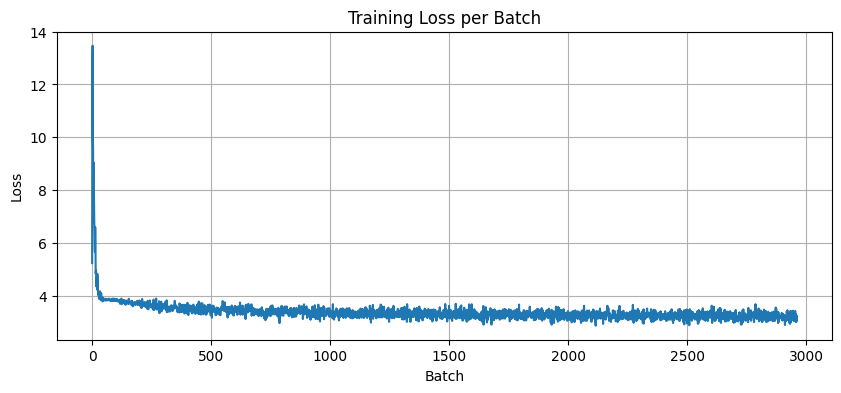

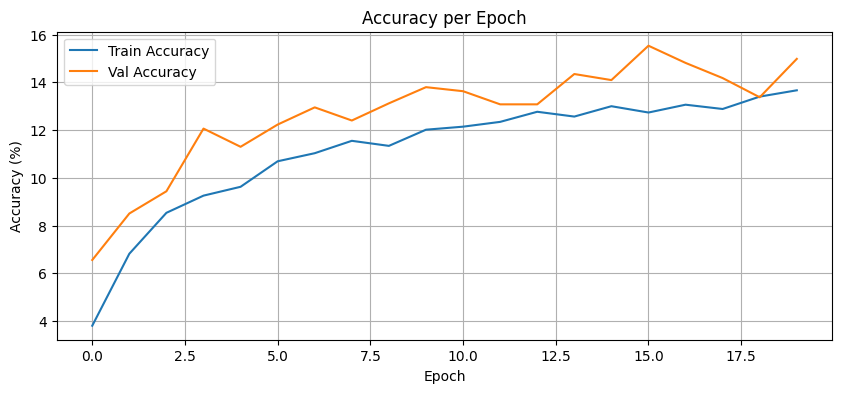

In [ ]:
trained_model, batch_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, test_loader, num_epochs=20)

In [ ]:
class_names = dataset.classes  # List of class names from your dataset

correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            label_idx = label.item()
            pred_idx = prediction.item()
            classname = class_names[label_idx]  # map index to class name
            total_pred[classname] += 1
            if label_idx == pred_idx:
                correct_pred[classname] += 1

for classname in class_names:
    if total_pred[classname] > 0:
        accuracy = 100 * correct_pred[classname] / total_pred[classname]
        print(f'Accuracy for class: {classname:20s} is {accuracy:.1f} %')
    else:
        print(f'Accuracy for class: {classname:20s} is N/A (no samples)')


Accuracy for class: African Violet (Saintpaulia ionantha) is 0.0 %
Accuracy for class: Aloe Vera            is 10.0 %
Accuracy for class: Anthurium (Anthurium andraeanum) is 0.0 %
Accuracy for class: Areca Palm (Dypsis lutescens) is 0.0 %
Accuracy for class: Asparagus Fern (Asparagus setaceus) is 0.0 %
Accuracy for class: Begonia (Begonia spp.) is 2.1 %
Accuracy for class: Bird of Paradise (Strelitzia reginae) is 0.0 %
Accuracy for class: Birds Nest Fern (Asplenium nidus) is 10.3 %
Accuracy for class: Boston Fern (Nephrolepis exaltata) is 0.0 %
Accuracy for class: Calathea             is 0.0 %
Accuracy for class: Cast Iron Plant (Aspidistra elatior) is 0.0 %
Accuracy for class: Chinese Money Plant (Pilea peperomioides) is 0.0 %
Accuracy for class: Chinese evergreen (Aglaonema) is 65.0 %
Accuracy for class: Christmas Cactus (Schlumbergera bridgesii) is 0.0 %
Accuracy for class: Chrysanthemum        is 0.0 %
Accuracy for class: Ctenanthe            is 1.4 %
Accuracy for class: Daffodils 

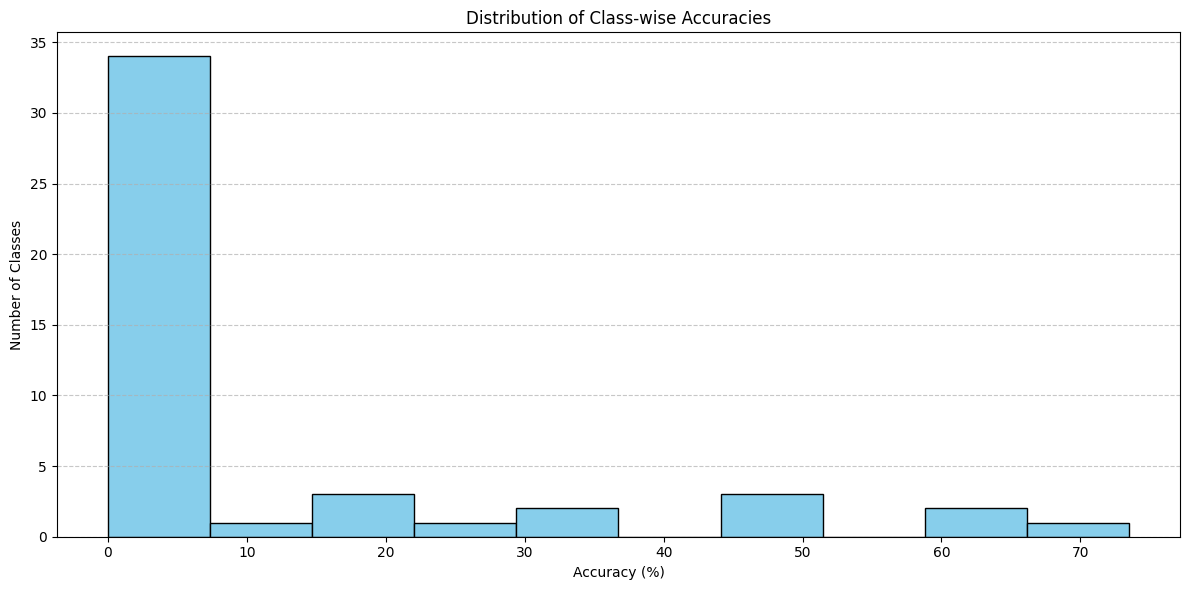

In [ ]:
classes = [
    "African Violet", "Aloe Vera", "Anthurium", "Areca Palm", "Asparagus Fern", "Begonia", "Bird of Paradise",
    "Birds Nest Fern", "Boston Fern", "Calathea", "Cast Iron Plant", "Chinese Money Plant", "Chinese evergreen",
    "Christmas Cactus", "Chrysanthemum", "Ctenanthe", "Daffodils", "Dracaena", "Dumb Cane", "Elephant Ear",
    "English Ivy", "Hyacinth", "Iron Cross begonia", "Jade plant", "Kalanchoe", "Lilium", "Lily of the valley",
    "Money Tree", "Monstera Deliciosa", "Orchid", "Parlor Palm", "Peace lily", "Poinsettia", "Polka Dot Plant",
    "Ponytail Palm", "Pothos", "Prayer Plant", "Rattlesnake Plant", "Rubber Plant", "Sago Palm", "Schefflera",
    "Snake plant", "Tradescantia", "Tulip", "Venus Flytrap", "Yucca", "ZZ Plant"
]

accuracies = [
    28.4, 0.0, 1.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5, 0.0, 0.0, 7.8, 1.6, 0.0, 2.9, 45.2, 0.0, 62.0, 0.0,
    0.0, 32.8, 1.9, 18.3, 0.0, 65.6, 73.5, 0.0, 20.0, 6.4, 0.0, 6.5, 50.8, 48.5, 0.0, 0.0, 0.0, 3.2, 0.0, 0.0,
    0.0, 6.3, 33.8, 0.0, 5.0, 0.0, 21.6
]

# Plotting the histogram
plt.figure(figsize=(12, 6))
plt.hist(accuracies, bins=10, edgecolor='black', color='skyblue')
plt.title('Distribution of Class-wise Accuracies')
plt.xlabel('Accuracy (%)')
plt.ylabel('Number of Classes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total

mean = torch.tensor([0.5463, 0.5445, 0.4464])
std = torch.tensor([0.2399, 0.2205, 0.2453])

def unnormalize(img_tensor):
    """Unnormalize a batch of images (tensor format)."""
    return img_tensor * std[:, None, None] + mean[:, None, None]

def show_misclassified(model, dataloader, device, class_names, max_images=10):
    model.eval()
    shown = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            wrong_indices = (predicted != labels).nonzero(as_tuple=True)[0]

            for idx in wrong_indices:
                img = images[idx].cpu()
                img = unnormalize(img)
                img = torchvision.transforms.ToPILImage()(img)

                plt.figure(figsize=(3, 3))
                plt.imshow(img)
                plt.title(f"Pred: {class_names[predicted[idx]]}\nTrue: {class_names[labels[idx]]}")
                plt.axis('off')
                plt.show()

                shown += 1
                if shown >= max_images:
                    return

✅ Final Validation Accuracy: 14.98%
✅ Final Test Accuracy: 14.92%


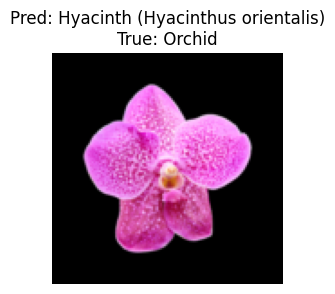

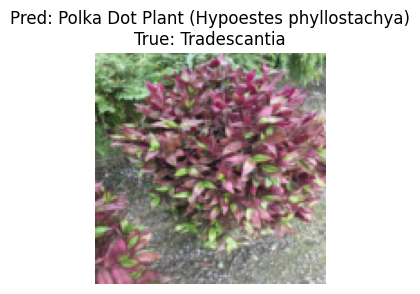

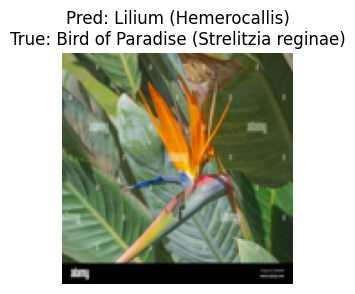

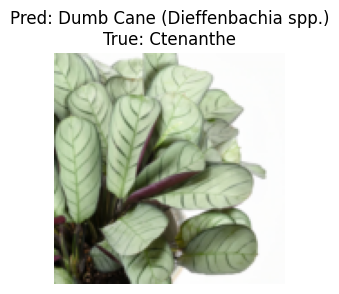

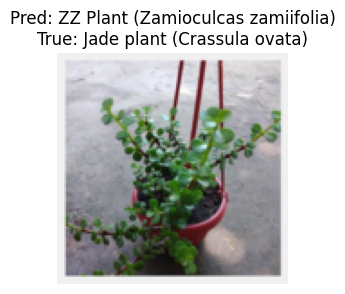

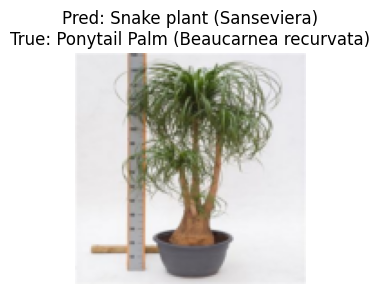

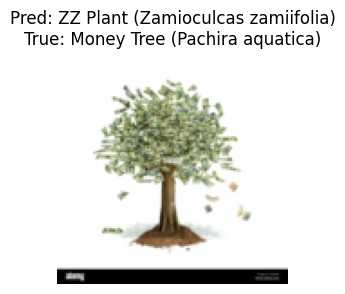

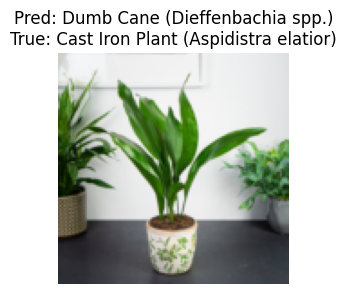

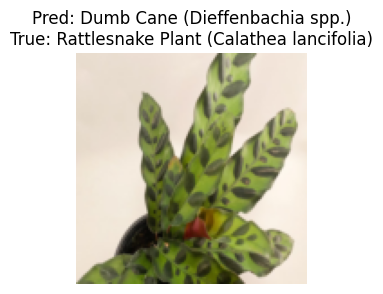

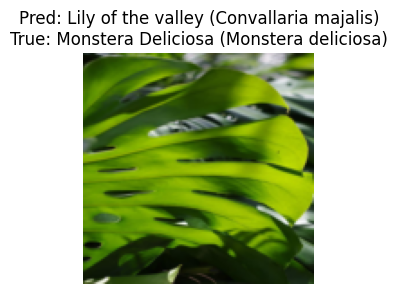

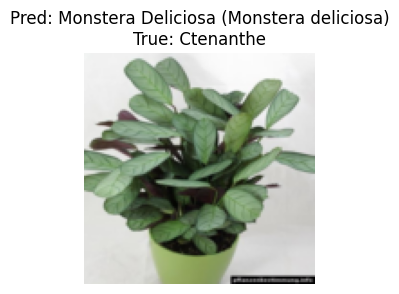

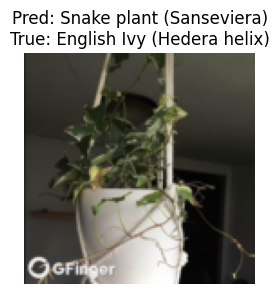

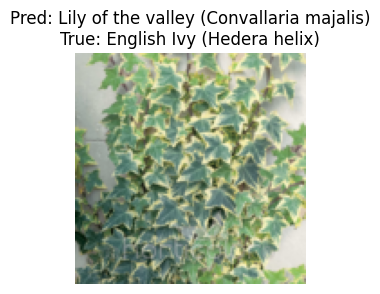

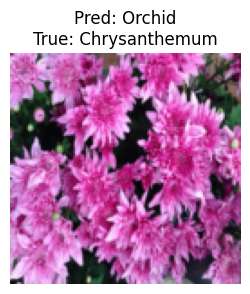

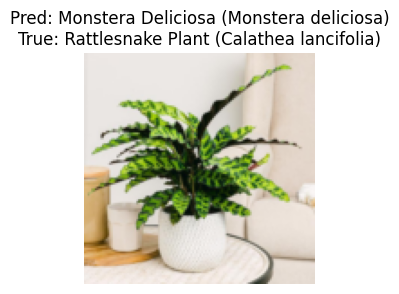

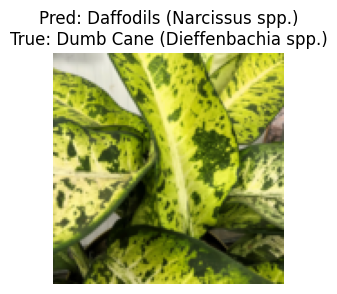

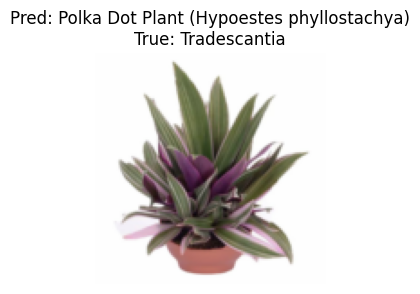

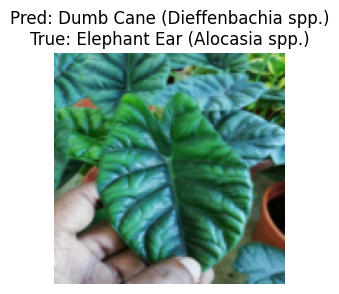

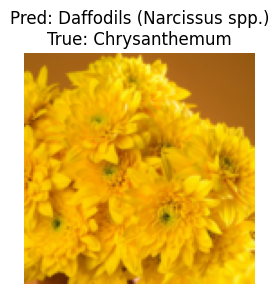

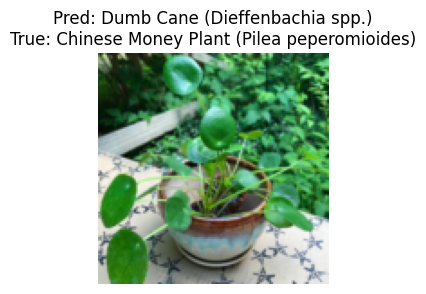

In [ ]:
# Accuracy
val_acc = evaluate(model, val_loader, device)
test_acc = evaluate(model, test_loader, device)

print(f"✅ Final Validation Accuracy: {val_acc:.2f}%")
print(f"✅ Final Test Accuracy: {test_acc:.2f}%")

# View misclassified samples
show_misclassified(model, test_loader, device, dataset.classes, max_images=20)

In [ ]:
# Create a mapping from original class names to new indices for the subset
# Identify classes with zero accuracy from the previous analysis
zero_acc_classes = [classname for classname, acc in zip(class_names, [100 * correct_pred[classname] / total_pred[classname] if total_pred[classname] > 0 else 0 for classname in class_names]) if acc == 0]

zero_acc_class_to_new_idx = {cls_name: new_idx for new_idx, cls_name in enumerate(zero_acc_classes)}

# Create a list of samples and new targets for the subset
subset_samples = []
subset_targets = []

# Iterate through the original dataset and select samples for the zero-accuracy classes
for path, original_label_idx in dataset.samples:
    original_class_name = dataset.classes[original_label_idx]
    if original_class_name in zero_acc_class_to_new_idx:
        new_label_idx = zero_acc_class_to_new_idx[original_class_name]
        subset_samples.append((path, new_label_idx))
        subset_targets.append(new_label_idx)

# Create a new dataset-like object or a custom Dataset
# For simplicity, we can create a list of (image, label) pairs and use a custom Dataset
class ZeroAccSubset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
        self.classes = zero_acc_classes # Assign the correct class names
        self.class_to_idx = zero_acc_class_to_new_idx

    def __getitem__(self, index):
        path, label = self.samples[index]
        image = Image.open(path).convert('RGB') # Ensure RGB
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.samples)

# Define the transform (you can use the same transform as before)
transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])


# Create the subset dataset using the new class
subset_dataset = ZeroAccSubset(subset_samples, transform=transform)

print(f"Created a subset dataset with {len(subset_dataset)} images from {len(zero_acc_classes)} classes.")
print(f"New class names in subset: {subset_dataset.classes}")
print(f"New class_to_idx mapping: {subset_dataset.class_to_idx}")

# Create a DataLoader for the subset dataset
subset_loader = DataLoader(subset_dataset, batch_size=32, shuffle=True)

print(f"Created a DataLoader for the subset with {len(subset_loader)} batches.")

Created a subset dataset with 11558 images from 36 classes.
New class names in subset: ['African Violet (Saintpaulia ionantha)', 'Anthurium (Anthurium andraeanum)', 'Areca Palm (Dypsis lutescens)', 'Asparagus Fern (Asparagus setaceus)', 'Bird of Paradise (Strelitzia reginae)', 'Boston Fern (Nephrolepis exaltata)', 'Calathea', 'Cast Iron Plant (Aspidistra elatior)', 'Chinese Money Plant (Pilea peperomioides)', 'Christmas Cactus (Schlumbergera bridgesii)', 'Chrysanthemum', 'Daffodils (Narcissus spp.)', 'Dracaena', 'Dumb Cane (Dieffenbachia spp.)', 'Elephant Ear (Alocasia spp.)', 'English Ivy (Hedera helix)', 'Hyacinth (Hyacinthus orientalis)', 'Jade plant (Crassula ovata)', 'Lilium (Hemerocallis)', 'Lily of the valley (Convallaria majalis)', 'Monstera Deliciosa (Monstera deliciosa)', 'Parlor Palm (Chamaedorea elegans)', 'Peace lily', 'Poinsettia (Euphorbia pulcherrima)', 'Polka Dot Plant (Hypoestes phyllostachya)', 'Ponytail Palm (Beaucarnea recurvata)', 'Pothos (Ivy arum)', 'Prayer Plan

In [ ]:
class SmallMScnn(nn.Module):
    def __init__(self, num_classes):
        super(SmallMScnn, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # downsample by factor 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # assuming input 128x128, after 2 pools: 128/4=32
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> 16 x 64 x 64
        x = self.pool(F.relu(self.conv2(x)))  # -> 32 x 32 x 32
        x = x.view(-1, 32 * 32 * 32)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# 80% train, 20% test split
total_size = len(subset_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

train_dataset, test_dataset = random_split(subset_dataset, [train_size, test_size])

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.manual_seed(42)  # for reproducibility
train_dataset, test_dataset = random_split(subset_dataset, [train_size, test_size])

Train samples: 9246, Test samples: 2312


In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = SmallMScnn(num_classes=len(zero_acc_classes)).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training with evaluation after each epoch
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # ---- Evaluation ----
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = correct / total * 100
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Test Accuracy: {test_acc:.2f}%")

Epoch 1/10 - Train Loss: 3.2668 - Test Accuracy: 21.52%
Epoch 2/10 - Train Loss: 2.6699 - Test Accuracy: 25.18%
Epoch 3/10 - Train Loss: 2.2177 - Test Accuracy: 30.63%
Epoch 4/10 - Train Loss: 1.7280 - Test Accuracy: 32.39%
Epoch 5/10 - Train Loss: 1.2307 - Test Accuracy: 33.10%
Epoch 6/10 - Train Loss: 0.7755 - Test Accuracy: 31.24%
Epoch 7/10 - Train Loss: 0.4228 - Test Accuracy: 30.59%
Epoch 8/10 - Train Loss: 0.2082 - Test Accuracy: 30.49%
Epoch 9/10 - Train Loss: 0.1167 - Test Accuracy: 29.00%
Epoch 10/10 - Train Loss: 0.0786 - Test Accuracy: 29.54%


In [ ]:
# Define the 12 target class names (exact folder names)
selected_classes = [
    'Anthurium (Anthurium andraeanum)',
    'Begonia (Begonia spp.)',
    'Calathea',
    'Chinese evergreen (Aglaonema)',
    'Ctenanthe',
    'Dracaena',
    'Dumb Cane (Dieffenbachia spp.)',
    'Money Tree (Pachira aquatica)',
    'Monstera Deliciosa (Monstera deliciosa)',
    'Prayer Plant (Maranta leuconeura)',
    'Snake plant (Sanseviera)',
    'Tradescantia'
]

# Define your full transform pipeline
final_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Reload dataset with transform
full_dataset = ImageFolder(root=root, transform=final_transform)

# Create a mapping from original class name to new class index (0-11)
original_class_to_new_idx = {class_name: new_idx for new_idx, class_name in enumerate(selected_classes)}

# Filter indices to include only selected classes
filtered_indices = [i for i, (_, original_label) in enumerate(full_dataset.samples) if full_dataset.classes[original_label] in selected_classes]

# Create a custom Dataset for the selected classes with remapped labels
class RemappedSubset(Dataset):
    def __init__(self, original_dataset, indices, class_mapping):
        self.original_dataset = original_dataset
        self.indices = indices
        self.class_mapping = class_mapping
        # Use the selected class names for this subset
        self.classes = selected_classes
        self.class_to_idx = original_class_to_new_idx


    def __getitem__(self, index):
        original_index = self.indices[index]
        img, original_label = self.original_dataset[original_index]
        original_class_name = self.original_dataset.classes[original_label]
        remapped_label = self.class_mapping[original_class_name] # Use class name for lookup


        # The transform is already applied when loading the full_dataset
        return img, remapped_label

    def __len__(self):
        return len(self.indices)

# Create the remapped subset dataset
remapped_subset_dataset = RemappedSubset(full_dataset, filtered_indices, original_class_to_new_idx)

# Get labels for splitting from the remapped dataset
remapped_labels = [label for _, label in remapped_subset_dataset]

# Stratified 80/20 split on the remapped labels
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(split.split(np.zeros(len(remapped_labels)), remapped_labels))

# Create train and test subsets from the remapped subset dataset
train_subset = Subset(remapped_subset_dataset, train_idx)
test_subset = Subset(remapped_subset_dataset, test_idx)


# DataLoaders (CPU-friendly settings)
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, num_workers=0)

print(f"Train samples: {len(train_subset)}")
print(f"Test samples: {len(test_subset)}")

Train samples: 3776
Test samples: 944


In [ ]:
# Convert labels list to a numpy array for proper indexing
#labels_np = np.array(labels)

train_targets = labels_np[train_idx]
test_targets = labels_np[test_idx]

print(np.unique(train_targets))
print(np.unique(test_targets))

[ 2  5  9 12 15 17 18 27 28 36 41 42]
[ 2  5  9 12 15 17 18 27 28 36 41 42]


In [ ]:
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Total training samples: {len(train_subset)}")
print(f"Total test samples: {len(test_subset)}")

Training batches: 118
Test batches: 30
Total training samples: 3776
Total test samples: 944


In [ ]:
num_classes = len(selected_classes)
print(f"Number of selected classes: {num_classes}")

Number of selected classes: 12


In [ ]:
def MScnn(num_classes):
    feature_extractor = nn.Sequential(
        nn.Conv2d(3, 6, kernel_size=5),    # → 220x220
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                # → 110x110
        nn.Conv2d(6, 16, kernel_size=5),   # → 106x106
        nn.ReLU(),
        nn.MaxPool2d(2, 2)                 # → 53x53
    )

    classifier = nn.Sequential(
        nn.Linear(16 * 53 * 53, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, num_classes)
    )

    def forward_function(x):
        x = feature_extractor(x)
        x = torch.flatten(x, 1)
        x = classifier(x)
        return x

    model = nn.Sequential(feature_extractor, nn.Flatten(), classifier)
    model.forward = forward_function
    return model

# Get number of classes
num_classes = len(selected_classes)

In [ ]:
model = MScnn(num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
def train_model(model, train_loader, test_loader, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        test_acc = evaluate_model(model, test_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, "
              f"Test Acc: {test_acc:.2f}%")

# --- Evaluation ---
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [ ]:
# Run training
train_model(model, train_loader, test_loader, num_epochs=10)

Epoch [1/10], Loss: 2.4640, Train Acc: 10.75%, Test Acc: 18.86%
Epoch [2/10], Loss: 2.2097, Train Acc: 23.09%, Test Acc: 25.85%
Epoch [3/10], Loss: 2.0342, Train Acc: 28.73%, Test Acc: 27.97%
Epoch [4/10], Loss: 1.9165, Train Acc: 33.02%, Test Acc: 29.87%
Epoch [5/10], Loss: 1.8056, Train Acc: 36.68%, Test Acc: 29.66%
Epoch [6/10], Loss: 1.6470, Train Acc: 42.03%, Test Acc: 32.42%
Epoch [7/10], Loss: 1.4319, Train Acc: 50.08%, Test Acc: 32.94%
Epoch [8/10], Loss: 1.0327, Train Acc: 64.22%, Test Acc: 32.63%
Epoch [9/10], Loss: 0.6522, Train Acc: 77.09%, Test Acc: 33.47%
Epoch [10/10], Loss: 0.3434, Train Acc: 88.08%, Test Acc: 33.47%


Train Accuracy: 94.57%

Per-class accuracy (%):
Anthurium (Anthurium andraeanum)        : 96.69%
Begonia (Begonia spp.)                  : 97.85%
Calathea                                : 97.35%
Chinese evergreen (Aglaonema)           : 85.64%
Ctenanthe                               : 98.18%
Dracaena                                : 100.00%
Dumb Cane (Dieffenbachia spp.)          : 85.45%
Money Tree (Pachira aquatica)           : 98.95%
Monstera Deliciosa (Monstera deliciosa) : 94.75%
Prayer Plant (Maranta leuconeura)       : 95.62%
Snake plant (Sanseviera)                : 97.16%
Tradescantia                            : 97.80%
Test Accuracy: 33.47%

Per-class accuracy (%):
Anthurium (Anthurium andraeanum)        : 60.44%
Begonia (Begonia spp.)                  : 19.15%
Calathea                                : 18.18%
Chinese evergreen (Aglaonema)           : 14.56%
Ctenanthe                               : 28.99%
Dracaena                                : 26.92%
Dumb Cane (Dieffenbach

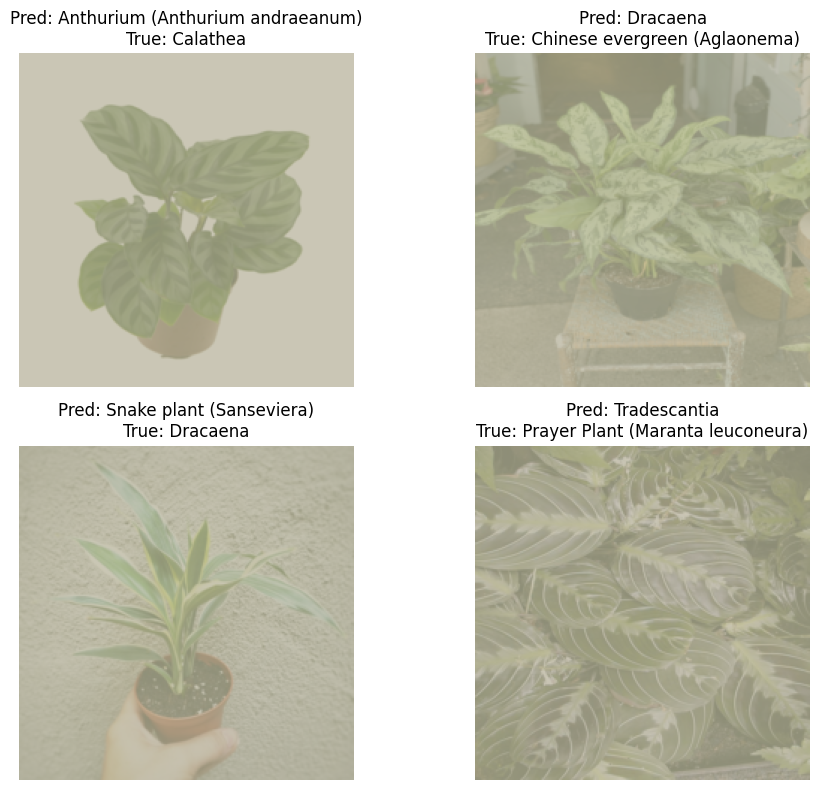

In [ ]:
# Put model in evaluation mode
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Get class names for interpretation
class_names = [name for name in selected_species]

def evaluate_model(model, dataloader, dataset_name='Test'):
    correct = 0
    total = 0
    class_correct = [0] * len(class_names)
    class_total = [0] * len(class_names)
    wrong_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                class_total[label] += 1
                if pred == label:
                    class_correct[label] += 1
                else:
                    if len(wrong_preds) < 4:
                        wrong_preds.append((images[i].cpu(), pred, label))

    overall_acc = 100 * correct / total
    print(f"{dataset_name} Accuracy: {overall_acc:.2f}%")

    # Per-class accuracy
    print(f"\nPer-class accuracy (%):")
    for i in range(len(class_names)):
        acc = 100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
        print(f"{class_names[i]:<40}: {acc:.2f}%")

    return overall_acc, wrong_preds
# Run on train and test
train_acc, _ = evaluate_model(model, train_loader, dataset_name='Train')
test_acc, wrong_preds = evaluate_model(model, test_loader, dataset_name='Test')

# Show 4 misclassified images
def imshow(img_tensor):
    img = img_tensor.clone().detach().cpu()

    # Use your dataset's normalization stats
    mean = torch.tensor([0.5496, 0.5536, 0.4606]).view(3, 1, 1)
    std = torch.tensor([0.2443, 0.2265, 0.2515]).view(3, 1, 1)

    img = img * std + mean  # Unnormalize
    img = img.numpy().transpose((1, 2, 0))  # C x H x W → H x W x C
    img = np.clip(img, 0, 1)

    return img
plt.figure(figsize=(10, 8))
for i, (img, pred, label) in enumerate(wrong_preds):
    plt.subplot(2, 2, i+1)
    plt.imshow(imshow(img))
    plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
# Risize data first
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])

# Load the dataset without normalization
dataset = ImageFolder(root='/content/house_plant_species/house_plant_species', transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
# Compute mean and std
mean = 0.
std = 0.
n_samples = 0

for images, _ in tqdm(loader):
    batch_samples = images.size(0)  # batch size (the last batch can be smaller)
    images = images.view(batch_samples, images.size(1), -1)  # (B, C, H*W)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    n_samples += batch_samples

mean /= n_samples
std /= n_samples

print(f"Computed mean: {mean}")
print(f"Computed std: {std}")

100%|██████████| 231/231 [10:17<00:00,  2.67s/it]

Computed mean: tensor([0.5463, 0.5445, 0.4464])
Computed std: tensor([0.2459, 0.2262, 0.2513])


In [ ]:
dataset = ImageFolder(root='/content/house_plant_species/house_plant_species')
labels = [label for _, label in dataset]

train_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), shear=15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.9, contrast=0.9),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Create an initial train/test split (e.g., 80% train+val, 20% test)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(split.split(np.zeros(len(labels)), labels))

train_val_subset = Subset(dataset, train_val_idx)
test_subset = Subset(dataset, test_idx)

# Wrapper to apply transforms to subsets [transformwrapper]
class TW(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.subset[index]
        return self.transform(image), label

    def __len__(self):
        return len(self.subset)

# Apply kfold cross-validation
labels_train_val = [labels[i] for i in train_val_idx]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels_train_val)), labels_train_val)):
    print(f"\n=== Fold {fold+1} ===")

    train_subset = Subset(train_val_subset, train_idx)
    val_subset = Subset(train_val_subset, val_idx)

    train_data = TW(train_subset, train_transform)
    val_data = TW(val_subset, val_transform)

    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2)

    test_data = TW(test_subset, test_transform)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)


=== Fold 1 ===

=== Fold 2 ===

=== Fold 3 ===

=== Fold 4 ===

=== Fold 5 ===


In [ ]:
# Convert labels list to a numpy array for proper indexing
labels_np = np.array(labels)

train_targets = labels_np[train_idx]
val_targets = labels_np[val_idx]
test_targets = labels_np[test_idx]

print(np.unique(train_targets))
print(np.unique(val_targets))
print(np.unique(test_targets))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


In [ ]:
# Full list of labels in the subset dataset
labels_np = np.array(labels)

# Ensure at least one sample from each class goes to train_val
unique_classes = np.unique(labels_np)

# Step 1: First extract at least one index for each class to include in train_val set
train_val_class_indices = []
test_candidates = []

for cls in unique_classes:
    cls_indices = np.where(labels_np == cls)[0]
    if len(cls_indices) >= 2:
        # Reserve one for test, rest for train_val
        train_val_class_indices.extend(cls_indices[:-1])
        test_candidates.append(cls_indices[-1])
    elif len(cls_indices) == 1:
        # If only one sample, add to train_val
        train_val_class_indices.extend(cls_indices)
    else:
        # Should not happen with unique_classes
        pass


# Step 2: Add remaining indices not yet included
all_indices = set(range(len(labels_np)))
already_used = set(train_val_class_indices + test_candidates)
remaining_indices = list(all_indices - already_used)

# Split remaining into train_val and test (stratified) if there are any remaining indices
if remaining_indices:
    remaining_labels = labels_np[remaining_indices]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    rem_train_val_idx, rem_test_idx = next(sss.split(np.zeros(len(remaining_labels)), remaining_labels))

    # Map to actual indices
    train_val_idx = np.array(train_val_class_indices + [remaining_indices[i] for i in rem_train_val_idx])
    test_idx = np.array(test_candidates + [remaining_indices[i] for i in rem_test_idx])

else:
    # If no remaining indices, train_val consists of all samples except the test candidates
    train_val_idx = np.array(train_val_class_indices)
    test_idx = np.array(test_candidates)


# === Now check class coverage ===
print("Train/Val classes:", np.unique(labels_np[train_val_idx]))
print("Test classes:     ", np.unique(labels_np[test_idx]))

# Step 3: Stratified K-Fold CV on the train_val set
labels_train_val = labels_np[train_val_idx]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels_train_val)), labels_train_val)):
    train_subset = Subset(train_val_subset, train_idx)
    val_subset = Subset(train_val_subset, val_idx)

    train_targets = labels_train_val[train_idx]
    val_targets = labels_train_val[val_idx]

    print(f"\n=== Fold {fold+1} ===")
    print("Train classes:", np.unique(train_targets))
    print("Val classes:  ", np.unique(val_targets))

Train/Val classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Test classes:      [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]

=== Fold 1 ===
Train classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Val classes:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]

=== Fold 2 ===
Train classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
Val classes:   [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]

=== F

In [ ]:
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Total training samples: {len(train_subset)}")
print(f"Total validation samples: {len(val_subset)}")
print(f"Total test samples: {len(test_subset)}")

Training batches: 148
Test batches: 47
Validation batches: 37
Total training samples: 11782
Total validation samples: 2945
Total test samples: 2955


In [ ]:
# Load pretrained VGG16 and modify for 47 classes
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.parameters():
    param.requires_grad = False  # Freeze feature extractor

# Replace final layer
vgg16.classifier[6] = nn.Linear(4096, 47)
vgg16 = vgg16.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = vgg16(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Train Acc: {acc:.2f}%")

# Evaluation
vgg16.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = vgg16(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 84.3MB/s]


Epoch [1/10], Loss: 408.5554, Train Acc: 27.68%
Epoch [2/10], Loss: 334.3769, Train Acc: 37.95%
Epoch [3/10], Loss: 326.3154, Train Acc: 40.38%
Epoch [4/10], Loss: 318.5549, Train Acc: 41.23%


In [ ]:
pip freeze > requirements.txt